# ABC/XYZ Analysis

Below is the pyspark code to produce ABC/XYZ analysis

Setup
```python
from pyspark.sql import Window
from pyspark.sql import functions as F

spark.sql('use zakhaand')
```

First of all, let's load the sales data grouped by items and compute total sales for each item
```python
sales_by_items = spark.sql('select item_id, sum(item_price*item_count_day) as sales, sum(item_count_day) as items_sold from '
                  'sales group by item_id order by sales desc')
totals = sales_by_items.agg(F.sum('sales'), F.sum('items_sold')).collect()
total_sales = totals[0][0]
total_sold = totals[0][1]

```

Secondly, let's prepare helper columns for abc/xyz analysis
```python
sales_percentages = sales_by_items.withColumn('proportion_of_sales', F.col('sales') / total_sales) \
    .withColumn('proportion_of_sold', F.col('items_sold') / total_sold) \
    .withColumn('cumulative_prop_sold', F.sum('proportion_of_sales').over(Window.orderBy(F.col('sales').desc())))

var_coef = spark \
    .sql('select month,item_id,sum(item_count_day) as items_sold from sales group by item_id, month') \
    .groupBy('item_id') \
    .agg(F.avg('items_sold').alias('avg_items_sold'), F.stddev_pop('items_sold').alias('stddev_items_sold')) \
    .withColumn('var_coef', F.col('stddev_items_sold') / F.col('avg_items_sold')) \
    .drop('avg_items_sold', 'stddev_items_sold')
abc_xyz = sales_percentages.join(var_coef, sales_by_items.item_id == var_coef.item_id, how='left') \
    .select(sales_percentages['*'], var_coef['var_coef'])
```

Now we can determine to which group each item belongs to using values from prepared columns

```python
abc_xyz = abc_xyz.withColumn('ABC', F.when(F.col('cumulative_prop_sold') <= 0.70, 'A')
                             .when((F.col('cumulative_prop_sold') > 0.70) & (F.col('cumulative_prop_sold') < 0.95), 'B')
                             .otherwise('C'))
abc_xyz = abc_xyz.withColumn('XYZ', F.when(F.col('var_coef') <= 0.1, 'X')
                             .when((F.col('var_coef') > 0.1) & (F.col('var_coef') < 0.25), 'Y')
                             .otherwise('Z')).cache()
```

Generate ABC/XYZ table

```python
abc_xyz_table = abc_xyz.groupBy('ABC', 'XYZ') \
    .agg(F.sum('sales').alias('total_sales'), F.sum('proportion_of_sales').alias('proportion_of_sales'),
         F.sum('proportion_of_sold').alias('prop_of_sold'), F.count('*').alias('number_of_items')) \
    .orderBy('ABC', 'XYZ')
abc_xyz_table.coalesce(1).write.csv('semestral-project/results/abc_xyz_table')
```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns


Table below shows statistics for each ABC/XYZ category. *number_of_items* column shows hom many products fall to each category, *prop_of_sold* column shows a proportion of items sold in the given category to the total amount of sold goods; *proportion_of_sales* shows proportion of sales in given category to the total sales (total amoun of money earned); *total_sales* column is the total money earned for the given category.

In [10]:
pd.read_csv('results/abc_xyz_table/abc_xyz_table.csv')

,ABC,XYZ,total_sales,proportion_of_sales,prop_of_sold,number_of_items
0,A,X,1.632660e+07,0.004803,0.001322,10
1,A,Y,1.051255e+08,0.030929,0.023491,38
2,A,Z,2.257495e+09,0.664179,0.393198,851
3,B,X,8.457336e+06,0.002488,0.001110,61
4,B,Y,4.944578e+07,0.014547,0.044610,362
5,B,Z,7.920936e+08,0.233042,0.382881,4607
6,C,X,9.870255e+06,0.002904,0.003268,4396
7,C,Y,3.609987e+06,0.001062,0.003334,216
8,C,Z,1.565020e+08,0.046045,0.146787,11266


Let's see a couple of products from each category

```python
items = spark.sql('select * from items')
abc_xyz_items = abc_xyz.join(items, items.item_id == abc_xyz.item_id)
win = Window.partitionBy('ABC', 'XYZ').orderBy('ABC', 'XYZ')
examples = abc_xyz_items.withColumn('rn', F.row_number().over(win)) \
    .where('rn<3').select('ABC', 'XYZ', 'item_name', 'item_category_name').orderBy('ABC', 'XYZ')
examples.coalesce(1).write.mode('overwrite').csv('semestral-project/results/abc_xyz_examples', header=True)
```

In [179]:
pd.read_csv('results/abc_xyz_examples/abc_xyz_examples.csv')

,ABC,XYZ,item_name,item_category_name
0,A,X,"Assassin's Creed: Синдикат. Биг Бен [PS4, русс...",Игры - PS4
1,A,X,Assassin's Creed: Синдикат. Специальное издани...,Игры - PS4
2,A,Y,"1С:Деньги 8 Электронная версия [PC, Цифровая в...",Программы - Для дома и офиса (Цифра)
3,A,Y,1С:Розница 8. Базовая версия,Программы - 1С:Предприятие 8
4,A,Z,007: КООРДИНАТЫ «СКАЙФОЛЛ»,Кино - DVD
5,A,Z,007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),Кино - Blu-Ray
6,B,X,1С-Битрикс: Управление сайтом - Малый бизнес [...,Программы - Для дома и офиса (Цифра)
7,B,X,Assassin's Creed: Единство. Золотое издание [P...,Игры PC - Цифра
8,B,Y,100 лучших народных песен (mp3-CD) (CD-Digipack),Музыка - MP3
9,B,Y,100 шедевров классики (mp3-CD) (Digipack),Музыка - MP3


# Exploratory analysis

## Distribution of average product prices

Pyspark code to produce distribution
```python
avg_price = spark.sql('select item_id, avg(item_price) as avg_item_price from sales group by item_id '
                      'order by avg_item_price desc')
avg_price.coalesce(1).write.mode('overwrite').csv('semestral-project/results/avg_price', header=True)
```

Let's plot the distribution. In order to make the histogram more clear I removed some outliers by selecting prices that fall only below 95th quantile 

,item_id,avg_item_price
count,21807.000000,21807.000000
mean,11098.699271,823.890413
std,6397.059362,2784.195667
min,0.000000,4.914856
25%,5551.500000,186.541323
50%,11105.000000,322.363636
75%,16647.500000,850.000000
max,22169.000000,307980.000000


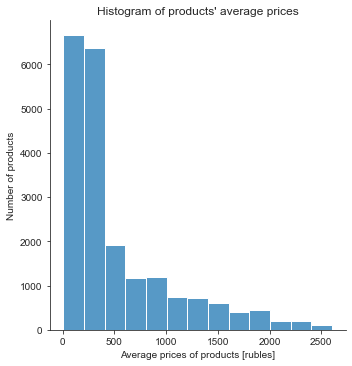

In [190]:
avg_prices = pd.read_csv('results/avg_price/avg_price.csv')
sns.displot(data=avg_prices[avg_prices['avg_item_price']<=avg_prices['avg_item_price'].quantile(0.95)], x='avg_item_price', binwidth=200);
plt.title('Histogram of products\' average prices');
plt.xlabel('Average prices of products [rubles]');
plt.ylabel('Number of products');
avg_prices.describe()

On the plot above we can see that the histogram is right-skewed and majority of products are priced below 1000 rubles.

## Top 10 products by average price

Let's see a list of top products by their average prices.

To get this list from spark

```python
items = spark.sql('select * from items')
top_10_avg_price = avg_price.join(items, avg_price.item_id == items.item_id) \
    .select(avg_price['*'], items['item_name']).orderBy(F.col('avg_item_price').desc()).limit(10)
top_10_avg_price.write.mode('overwrite').csv('semestral-project/results/top_10_avg_price', header=True)
```

In [54]:
pd.read_csv('results/top_10_avg_price/top_10_avg_price.csv')

,item_id,avg_item_price,item_name
0,6066,307980.000000,Radmin 3 - 522 лиц.
1,13199,50999.000000,Коллекционные шахматы (Властелин Колец)
2,7241,49782.000000,UserGate Proxy & Firewall 6.X с модулем фильтр...
3,7238,42000.000000,UserGate Proxy & Firewall 6.X до 100 сессий
4,14173,40900.000000,Лицензия 1С-Битрикс: Управление сайтом - Эксперт
5,13403,39990.500000,"\Комплект \""\""Microsoft Xbox One 1TB Limited ..."
6,5748,35132.857143,Photoshop 13 Windows Russian BOX
7,13503,34990.000000,Комплект «Sony PlayStation 4 (1Tb) Black (CUH-...
8,13448,34823.333333,Комплект Sony PlayStation 4 (1Tb) Black (CUH-1...
9,2410,34713.500000,CorelDRAW Graphics Suite X6 - Small Business E...


## Distribution of average prices by 5 biggest categories

Let's firstly findout 5 categories with most sales

```python
sales = spark.sql('select * from sales')
sales_items = sales.join(items, sales.item_id == items.item_id) \
    .select(sales['*'], items['item_name'], items['item_category_id'], items['item_category_name']) \
    .cache()
categories_stats = sales_items.groupBy('item_category_id', 'item_category_name') \
    .agg(F.avg('item_price').alias('avg_item_price'), F.sum('item_count_day').alias('items_sold')).cache()
biggest_5_cats = categories_stats.orderBy(F.col('items_sold').desc()).limit(5)
biggest_5_cats.coalesce(1).write.mode('overwrite').csv('semestral-project/results/biggest_5_cats', header=True)
```

In [55]:
pd.read_csv('results/biggest_5_cats/biggest_5_cats.csv')

,item_category_id,item_category_name,avg_item_price,items_sold
0,40,Кино - DVD,256.339150,634171
1,30,Игры PC - Стандартные издания,499.199532,456540
2,55,Музыка - CD локального производства,286.209370,348591
3,19,Игры - PS3,1512.044319,254887
4,37,Кино - Blu-Ray,434.289667,203284


From the table above we can see that most sold products belong to entertaining categories.

And now we can filter out only products from this categories and produce the histogram by each category

```python
average_prices_by_5_biggest_cats = sales_items.filter('item_category_id in (40, 30,55,19,37)') \
    .groupBy('item_id', 'item_category_id', 'item_category_name') \
    .agg(F.avg('item_price').alias('avg_item_price'))
average_prices_by_5_biggest_cats.coalesce(1).write.mode('overwrite') \
    .csv('semestral-project/results/avg_price_biggest_5_cats', header=True)
```

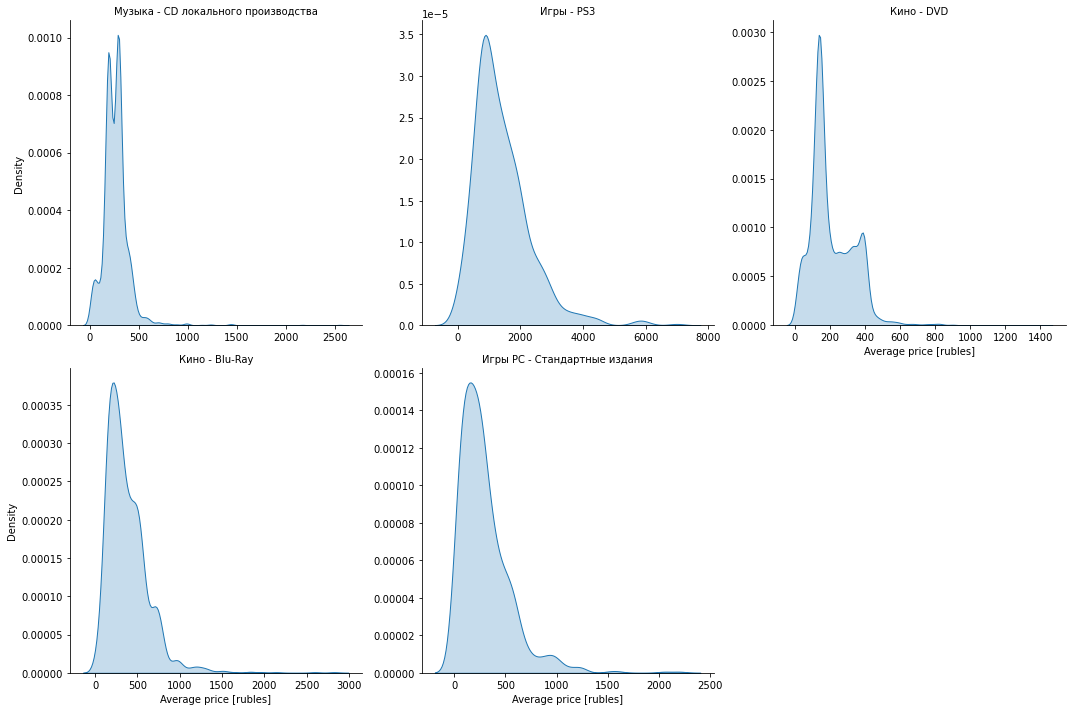

In [126]:
avg_price_by_5_cats = pd.read_csv('results/avg_price_biggest_5_cats/avg_price_biggest_5_cats.csv')

g = sns.displot(avg_price_by_5_cats, x='avg_item_price', col='item_category_name',kind='kde',col_wrap=3,fill=True,facet_kws={'sharey':False, 'sharex':False})
g.set_axis_labels("Average price [rubles]", "Density");
g.set_titles(col_template="{col_name}");

On the plot above we can see a distribution of average prices by each of five biggest categories. We can see that category "Игры - PS3" has the widest range of prices, while other categories do not vary as much and prices in other categories are below 1500 rubles.

## Distribution of prices by categories

To get average prices by categories let's reuse dataframe from previous task

```python
avg_price_by_cats = sales_items.groupBy('item_category_id') \
    .agg(F.avg('item_price').alias('avg_item_price'))
avg_price_by_cats.coalesce(1).write.mode('overwrite') \
    .csv('semestral-project/results/avg_price_by_cats', header=True)
```

Let's plot the histogram of average prices by categories

,item_category_id,avg_item_price
count,84.000000,84.000000
mean,41.500000,1855.807949
std,24.392622,3678.776768
min,0.000000,4.931371
25%,20.750000,296.652343
50%,41.500000,816.267141
75%,62.250000,1584.344768
max,83.000000,22889.299107


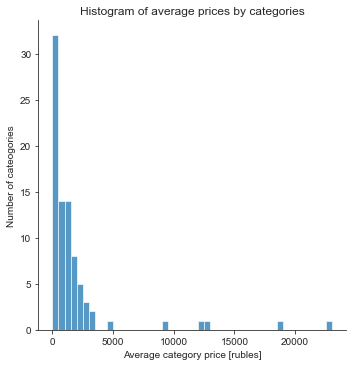

In [191]:
avg_prices_by_cats = pd.read_csv('results/avg_price_by_cats/avg_price_by_cats.csv')
sns.displot(data=avg_prices_by_cats, x='avg_item_price', binwidth=500)
plt.title('Histogram of average prices by categories');
plt.xlabel('Average category price [rubles]');
plt.ylabel('Number of cateogories');
avg_prices_by_cats.describe()

We can see that the histogram is right-skewed and there are some categories, whose average prices differ significantly so we can check out what are those categories in the next section.

## Top 10 categories by average price

Let's see top 10 categories by average prices.

```python
top_10_cats = categories_stats.orderBy(F.col('avg_item_price').desc()).limit(10)
top_10_cats.write.mode('overwrite').csv('semestral-project/results/top_10_cats', header=True)
```

In [113]:
pd.read_csv('results/top_10_cats/top_10_cats.csv')

,item_category_id,item_category_name,avg_item_price,items_sold
0,12,Игровые консоли - PS4,22889.299107,13230
1,16,Игровые консоли - XBOX ONE,18682.560994,2827
2,11,Игровые консоли - PS3,12686.742020,6403
3,15,Игровые консоли - XBOX 360,12024.564619,5980
4,14,Игровые консоли - PSVita,9263.114438,3062
5,13,Игровые консоли - PSP,4572.157125,357
6,74,Программы - MAC (Цифра),3403.571429,59
7,60,Музыка - Подарочные издания,3319.487508,1497
8,20,Игры - PS4,2791.779820,127319
9,7,Аксессуары - XBOX ONE,2713.552295,5358


So from this table we can conclude that the most expensive category of products are gaming consoles, like PS4, XBOX ONE, etc.

## Top 10 products by overall sales from AX, BX and CZ categories

To get most sold items from categories from ABC/XYZ analysis let's reuse results from previous part and find sutable products

```python
top_10_ax = abc_xyz.filter('ABC="A" and XYZ="X"') \
    .orderBy(F.col('sales').desc()).limit(10) \
    .select(abc_xyz['item_id'], abc_xyz['sales'], abc_xyz['ABC'], abc_xyz['XYZ'])
top_10_ax = top_10_ax.join(items, items.item_id == top_10_ax.item_id, how='left') \
    .select(top_10_ax['*'], items['item_name'])
top_10_ax.write.mode('overwrite').csv('semestral-project/results/top_10_ax',header=True)

top_10_bx = abc_xyz.filter('ABC="B" and XYZ="X"') \
    .orderBy(F.col('sales').desc()).limit(10) \
    .select(abc_xyz['item_id'], abc_xyz['sales'], abc_xyz['ABC'], abc_xyz['XYZ'])
top_10_bx = top_10_bx.join(items, items.item_id == top_10_bx.item_id, how='left') \
    .select(top_10_bx['*'], items['item_name'])
top_10_bx.write.mode('overwrite').csv('semestral-project/results/top_10_bx', header=True)

top_10_cz = abc_xyz.filter('ABC="C" and XYZ="Z"') \
    .orderBy(F.col('sales').desc()).limit(10) \
    .select(abc_xyz['item_id'], abc_xyz['sales'], abc_xyz['ABC'], abc_xyz['XYZ'])
top_10_cz = top_10_cz.join(items, items.item_id == top_10_cz.item_id, how='left') \
    .select(top_10_cz['*'], items['item_name'])
top_10_cz.write.mode('overwrite').csv('semestral-project/results/top_10_cz', header=True)
```

### Top 10 products from AX category

In [117]:
pd.read_csv('results/top_10_ax/top_10_ax.csv')

,item_id,sales,ABC,XYZ,item_name
0,7223,3.178372e+06,A,X,"Uncharted: Натан Дрейк. Коллекция [PS4, русска..."
1,1583,2.584790e+06,A,X,Assassin's Creed: Синдикат. Специальное издани...
2,7224,2.256936e+06,A,X,Uncharted: Натан Дрейк. Коллекция. Специальное...
3,1578,2.085006e+06,A,X,"Assassin's Creed: Синдикат. Биг Бен [PS4, русс..."
4,3838,1.489156e+06,A,X,Halo 5: Guardians. Коллекционное издание [Xbox...
5,10202,1.045725e+06,A,X,Ведьмак 3: Дикая Охота - Дополнение Каменные С...
6,10201,1.031493e+06,A,X,Ведьмак 3: Дикая Охота - Дополнение Каменные С...
7,13449,1.028598e+06,A,X,Комплект Sony PlayStation 4 (500 Gb) Black (CU...
8,1586,8.681428e+05,A,X,"Assassin's Creed: Синдикат. Чаринг-Кросс [PS4,..."
9,3756,7.583800e+05,A,X,"Guitar Hero Live (Гитара + игра) [PS4, английс..."


This tables demonstrates to us that the products with high volumes of sales and stable demand are mostly video games.

### Top 10 products from BX category

In [120]:
pd.read_csv('results/top_10_bx/top_10_bx.csv')

,item_id,sales,ABC,XYZ,item_name
0,13403,517877.000000,B,X,"\Комплект \""\""Microsoft Xbox One 1TB Limited ..."
1,12124,506842.000000,B,X,Игровая консоль. Xbox One 1 TB (5C6-00061)
2,3837,462407.870117,B,X,"Halo 5: Guardians [Xbox One, русская версия] (..."
3,1581,429997.000000,B,X,"Assassin's Creed: Синдикат. Грачи [PS4, русска..."
4,3729,429785.000000,B,X,"Grand Theft Auto V (предзаказ3) [PC, Цифровая ..."
5,5670,369433.500000,B,X,PS4: Контроллер игровой беспроводной серый (Du...
6,13448,313410.000000,B,X,Комплект Sony PlayStation 4 (1Tb) Black (CUH-1...
7,6066,307980.000000,B,X,Radmin 3 - 522 лиц.
8,5748,245930.000000,B,X,Photoshop 13 Windows Russian BOX
9,3839,244965.000000,B,X,Halo 5: Guardians. Ограниченное издание [Xbox ...


The table below shows products with stable demand, but lower volume of sales than items in the previous table. This also shows that products with most stable demand are mostly video games.

### Top 10 products from CZ category

In [121]:
pd.read_csv('results/top_10_cz/top_10_cz.csv')

,item_id,sales,ABC,XYZ,item_name
0,15199,47359.000000,C,Z,Музыкальная шкатулка/LOVE STORY
1,8031,47341.199997,C,Z,ZZ TOP Greatest Hits
2,8701,47338.300049,C,Z,БЕГЛЕЦЫ (регион)
3,14359,47317.000000,C,Z,МАРА Почувствуй разницу Live 2CD+DVD (фирм.)
4,6350,47306.000000,C,Z,STING Ten Summoner`s Tales LP
5,11542,47286.700195,C,Z,Жетоны Wolfenstein The New Order Dogtag Blazko...
6,16515,47284.409714,C,Z,ОДНАЖДЫ В ИРЛАНДИИ (BD)
7,3788,47225.000000,C,Z,HELLOWEEN Straight Out Of Hell
8,10697,47200.000000,C,Z,Государственные и муниципальные учреждения: уч...
9,21993,47192.000000,C,Z,Шпионский танк Rover Spy Tank


Products from CZ category represent items with most fluctuating demand and lowest volume of sales. Such products are sold quite rarely and it's important not to overstock them.

## Sales timeline

### Sales by days

Code to get sales by dates from pyspark

```python
sales_by_day = spark.sql('select record_date, sum(item_price*item_count_day) as sales from sales group by record_date '
                         'order by record_date')
sales_by_day.coalesce(1).write.mode('overwrite').csv('semestral-project/results/sales_by_day', header=True)
```

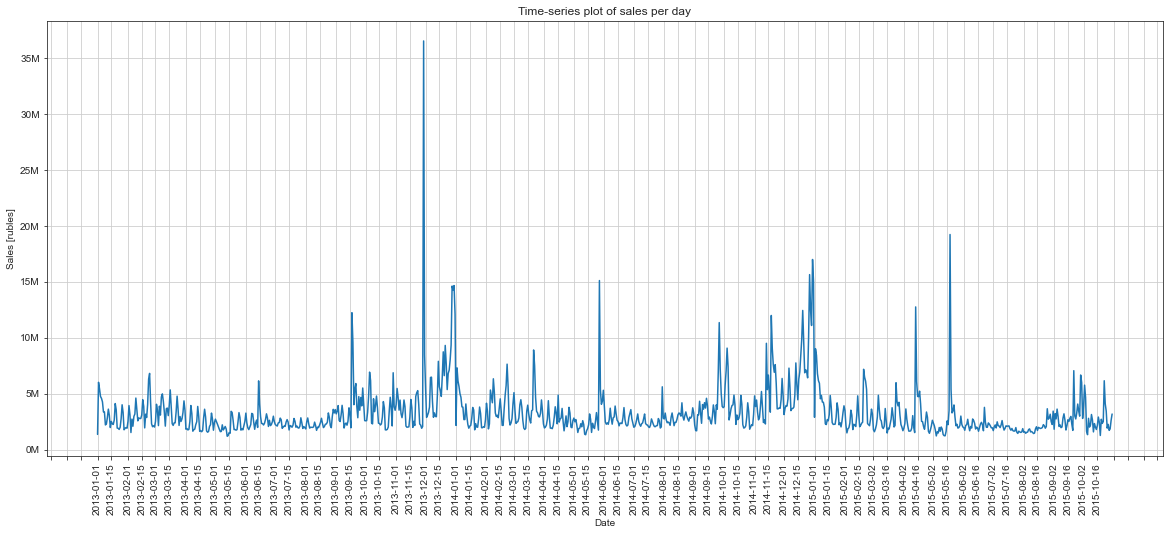

In [182]:
sales_by_day = pd.read_csv('results/sales_by_day/sales_by_day.csv')
locator = mdates.DayLocator((1,15))
fig = plt.figure(figsize=(20,8))
ax = sns.lineplot(data=sales_by_day, x='record_date', y='sales')
ax.xaxis.set_major_locator(locator);
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/10**6:,.0f}M'))
plt.xticks(rotation=90)
plt.grid()
plt.title('Time-series plot of sales per day')
plt.xlabel('Date')
plt.ylabel('Sales [rubles]')
plt.show()

This plot shows to us the total sales per each day (in order to make plot more clear x axis displays dates only for beggining and mid of a month). From this plot we can clearly see fluctuations by days and we can also see several peaks. As expected, the highest sales are near the winter holidays and there are peaks on the first days of june, it can be attribited to the start of summer holidays in schools and higher sales of the video games, since they are the most sold items.

### Sales by weeks

Code to get sales by weeks

```python
sales = spark.sql('select * from sales').cache()
sales_w_week = sales.withColumn('week_of_year', F.weekofyear(sales.record_date))
sales_by_week = sales_w_week.groupBy('year', 'week_of_year') \
    .agg(F.sum(sales_w_week.item_price * sales_w_week.item_count_day).alias('sales_per_week')) \
    .withColumn('year-week', F.concat(F.col('year'), F.lit('-'), F.col('week_of_year'))) \
    .orderBy('year', 'week_of_year')
```

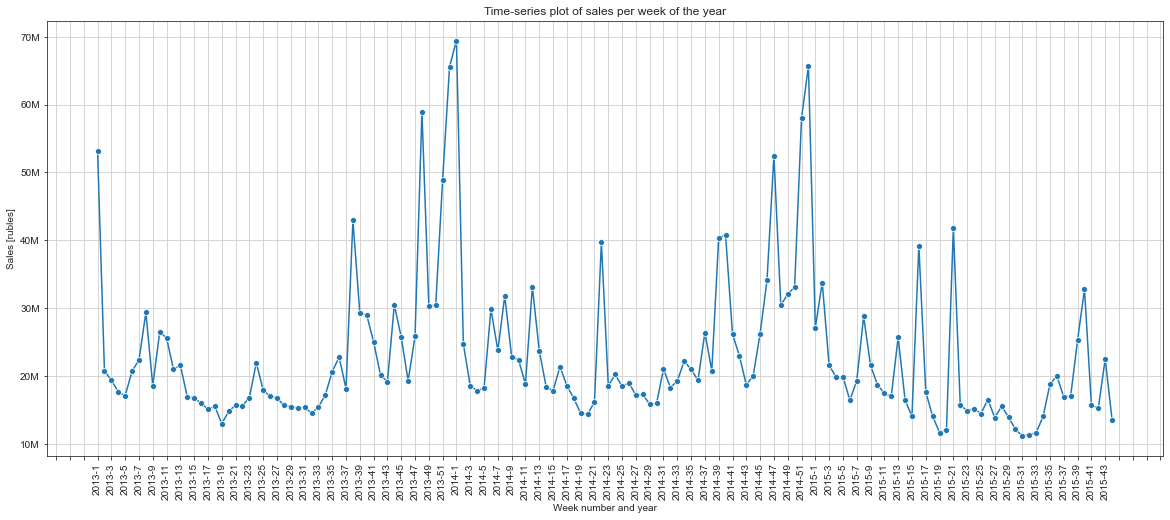

In [151]:
sales_by_week = pd.read_csv('results/sales_by_week/sales_by_week.csv')
plt.figure(figsize=(20,8))
ax = sns.lineplot(data=sales_by_week, x='year-week', y='sales_per_week', marker='o')
ax.xaxis.set_major_locator(ticker.MultipleLocator(2));
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/10**6:,.0f}M'))
plt.xticks(rotation=90);
plt.grid();
plt.title('Time-series plot of sales per week of the year');
plt.xlabel('Week number and year');
plt.ylabel('Sales [rubles]');

This plots demonstartes to us the change of total sales per week of each year (to make a plot more clear we only display every 2nd week on the x axis). On this plot we can see the same tendencies as on the previous plot but with less noise.

### Sales by months

```python
sales_by_month = sales.groupBy('year', 'month') \
    .agg(F.sum(sales_w_week.item_price * sales_w_week.item_count_day).alias('sales_by_month'))\
    .withColumn('year-month', F.concat(F.col('year'), F.lit('-'), F.col('month')))\
    .orderBy('year', 'month')
```

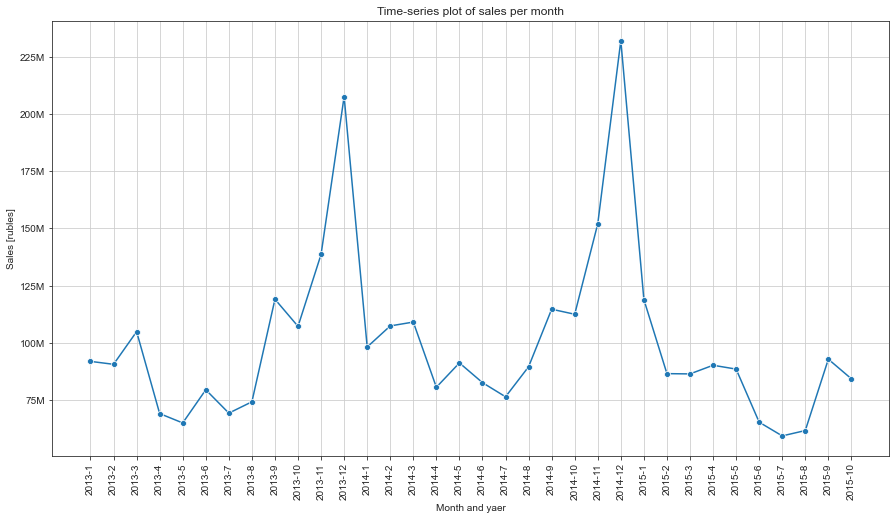

In [150]:
sales_by_month = pd.read_csv('results/sales_by_month/sales_by_month.csv')
plt.figure(figsize=(15,8))
ax = sns.lineplot(data=sales_by_month, x='year-month', y='sales_by_month', marker='o')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/10**6:,.0f}M'))
plt.xticks(rotation=90);
plt.grid()
plt.title('Time-series plot of sales per month')
plt.xlabel('Month and yaer')
plt.ylabel('Sales [rubles]');

This plot shows to us changes of total sales per each month. From here we can see that most profitable months are November and December and that the lowest sales are during the summer, most probably due to the fact that most people have vacations during this time and don't spend money on software.

## Sales by days of week, days of month, weeks, months

### Sales by days of week

In this section we will analyse sales tendencies by days of weeks, days of month, weeks of year and months. For this we will only take into account data for 20013 and 2014 since data for the 2015 is not complete and may skew the results.

Firstly we will filter out data for 2015 and produce analysis by days of week.

```python
sales_w_days = sales_w_week.withColumn('day_of_week', F.dayofweek(sales_w_week.record_date)) \
    .filter("year < 2015").cache()

sales_by_days_of_week = sales_w_days.groupBy('day_of_week') \
    .agg(F.sum(sales_w_days.item_price * sales_w_days.item_count_day).alias('sales')) \
    .orderBy('day_of_week')
sales_by_days_of_week.coalesce(1).write.mode('overwrite').csv('semestral-project/results/sales_by_days_of_week',
                                                              header=True)
```

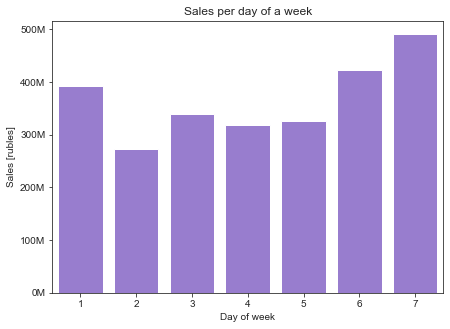

In [156]:
sales_by_days_of_week = pd.read_csv('results/sales_by_days_of_week/sales_by_days_of_week.csv')
plt.figure(figsize=(7,5))
ax = sns.barplot(data=sales_by_days_of_week, x='day_of_week', y='sales', color='mediumpurple')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/10**6:,.0f}M'))
plt.title('Sales per day of a week')
plt.xlabel('Day of week')
plt.ylabel('Sales [rubles]');

In the plot above we see the distribution of sales by days of week, where 1 is Monday and 7 is Sunday. From this plot we can indicate that people by more on weekends and Monday, while during Tuesday people buy less.

### Sales by days of month

Let's see how sales are distributed by days of month
```python
sales_by_days_of_month = sales_w_days.groupBy('day') \
    .agg(F.sum(sales_w_days.item_price * sales_w_days.item_count_day).alias('sales')).orderBy('day')
sales_by_days_of_month.coalesce(1).write.mode('overwrite').csv('semestral-project/results/sales_by_days_of_month',header=True)
```

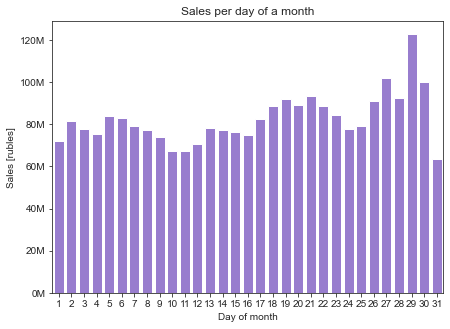

In [155]:
sales_by_days_of_week = pd.read_csv('results/sales_by_days_of_month/sales_by_days_of_month.csv')
plt.figure(figsize=(7,5))
ax = sns.barplot(data=sales_by_days_of_week, x='day', y='sales', color='mediumpurple')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/10**6:,.0f}M'))
plt.title('Sales per day of a month')
plt.xlabel('Day of month')
plt.ylabel('Sales [rubles]');

This plot shows us the distribution of sales by each calendar day of month. The first thing is that 31st day is not very informative, since this day occures only in half months. The slight increases in sales at the begining and mid-end of month can be explained by the fact that people usualy get salary at this time and also the spike and the end of month can be linked to the fact that people payed out all the bills and have some spare money.

### Sales by week of year

```python
sales_by_week_of_year = sales_w_days.groupBy('week_of_year') \
    .agg(F.sum(sales_w_days.item_price * sales_w_days.item_count_day).alias('sales')).orderBy('week_of_year')
sales_by_week_of_year.coalesce(1).write.mode('overwrite').csv('semestral-project/results/sales_by_week_of_year',header=True)
```

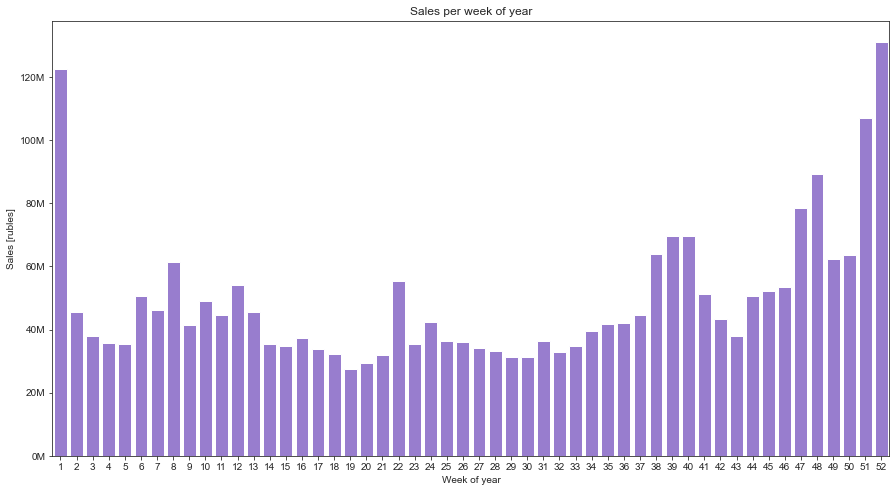

In [157]:
sales_by_days_of_week = pd.read_csv('results/sales_by_week_of_year/sales_by_week_of_year.csv')
plt.figure(figsize=(15,8))
ax=sns.barplot(data=sales_by_days_of_week, x='week_of_year', y='sales', color='mediumpurple')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/10**6:,.0f}M'))
plt.title('Sales per week of year')
plt.xlabel('Week of year')
plt.ylabel('Sales [rubles]');

On this plot we can see distribution of sales by weeks of year. Here we can see the same tendency as before that sales go up during last weeks of year, but here we can also clearcly see that the first week of January has roughly the same sales as the last week of December. This can be explained by the fact that Christmas in Russia is on the 7th of Januray and people may continue to buy presents during this time.

### Sales by month of year

```python
sales_by_month_of_year = sales_w_days.groupBy('month') \
    .agg(F.sum(sales_w_days.item_price * sales_w_days.item_count_day).alias('sales')).orderBy('month')
sales_by_month_of_year.coalesce(1).write.mode('overwrite').csv('semestral-project/results/sales_by_month_of_year',header=True)
```

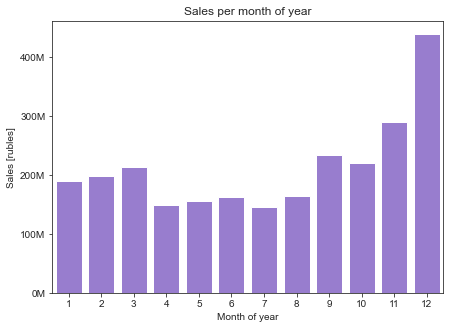

In [186]:
sales_by_days_of_week = pd.read_csv('results/sales_by_month_of_year/sales_by_month_of_year.csv')
plt.figure(figsize=(7,5))
ax = sns.barplot(data=sales_by_days_of_week, x='month', y='sales', color='mediumpurple')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/10**6:,.0f}M'))
plt.title('Sales per month of year')
plt.xlabel('Month of year')
plt.ylabel('Sales [rubles]');

Here we see distribution of sales by months of year. No surprises here, same trends as we observed in previous sections - sales go up during last months of year and decrease during summer.

## Distribution of sales by categories

In this section we will make similar analysis as in the section before, but we will examine the destribution of sales by 5 biggest categorie. These are the same categories as mentioned before.

In [188]:
category_names = {19:'Игры - PS3', 30:'Игры PC - Стандартные издания',37:'Кино - Blu-Ray',40:'Кино - DVD', 55: 'Музыка - CD локального производства'}
cat_names = pd.DataFrame([[k,v] for k,v in category_names.items()],columns=['item_category_id', 'item_category_name']);

### Distribution of sales by categories and days of week

Code to get statistics by categories and days from pyspark
```python
sales_w_days_cats = sales_w_days.join(items, sales_w_days.item_id == items.item_id) \
    .select(sales_w_days['*'], items.item_category_id) \
    .filter('item_category_id in (40, 30,55,19,37)')

sales_5_cats_by_days_of_week = sales_w_days_cats.groupBy('day_of_week', 'item_category_id') \
    .agg(F.sum(sales_w_days.item_price * sales_w_days.item_count_day).alias('sales')) \
    .orderBy('day_of_week')
sales_5_cats_by_days_of_week.coalesce(1).write.mode('overwrite') \
    .csv('semestral-project/results/sales_5_cats_by_days_of_week', header=True)
```

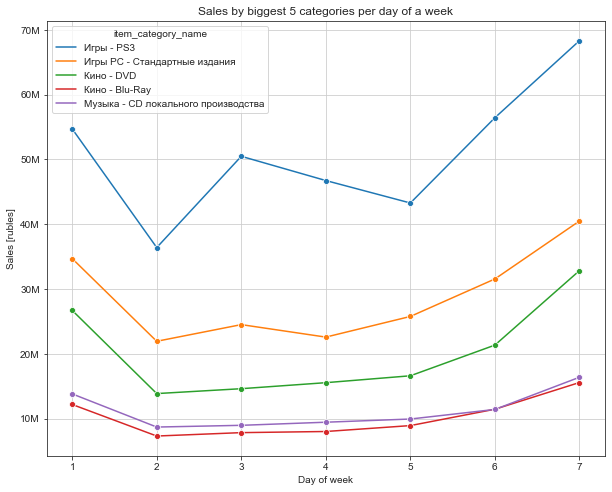

In [172]:
sales_5_cats_by_days_of_week = pd.read_csv('results/sales_5_cats_by_days_of_week/sales_5_cats_by_days_of_week.csv').join(cat_names.set_index('item_category_id'), on='item_category_id')
plt.figure(figsize=(10,8))
ax = sns.lineplot(data=sales_5_cats_by_days_of_week, x='day_of_week', y='sales',hue='item_category_name', palette='tab10', marker='o')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/10**6:,.0f}M'))
plt.title('Sales by biggest 5 categories per day of a week')
plt.xlabel('Day of week')
plt.ylabel('Sales [rubles]');
plt.grid();

The plot above shows distribution of sales by days of week and 5 categories. This graph confirms observation above, most sold categories of products behave in similar way as all products in general.

### Distribution of sales by categories and day of month

```python
sales_5_cats_by_days_of_month = sales_w_days_cats.groupBy('day', 'item_category_id') \
    .agg(F.sum(sales_w_days.item_price * sales_w_days.item_count_day).alias('sales')).orderBy('day')
sales_5_cats_by_days_of_month.coalesce(1).write.mode('overwrite') \
    .csv('semestral-project/results/sales_5_cats_by_days_of_month', header=True)
```

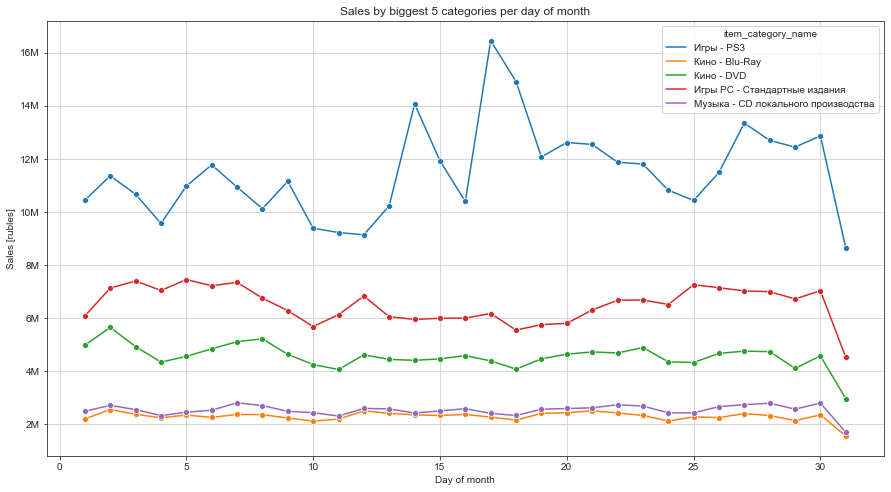

In [173]:
plt.figure(figsize=(15,8))
sales_5_cats_by_days_of_month = pd.read_csv('results/sales_5_cats_by_days_of_month/sales_5_cats_by_days_of_month.csv').join(cat_names.set_index('item_category_id'), on='item_category_id')
ax = sns.lineplot(data=sales_5_cats_by_days_of_month, x='day', y='sales',hue='item_category_name', palette='tab10', marker='o')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/10**6:,.0f}M'))
plt.title('Sales by biggest 5 categories per day of month')
plt.xlabel('Day of month')
plt.ylabel('Sales [rubles]');
plt.grid()

This plot displays distribution of sales by days of month and 5 most sold categories. Here we can see that PS3 games have spikes in the middle of month, while other categories are relatively stable.

### Distribution of sales by categories and week of year

```python
sales_5_cats_by_week_of_year = sales_w_days_cats.groupBy('week_of_year', 'item_category_id') \
    .agg(F.sum(sales_w_days.item_price * sales_w_days.item_count_day).alias('sales')).orderBy('week_of_year')
sales_5_cats_by_week_of_year.coalesce(1).write.mode('overwrite') \
    .csv('semestral-project/results/sales_5_cats_by_week_of_year', header=True)
```

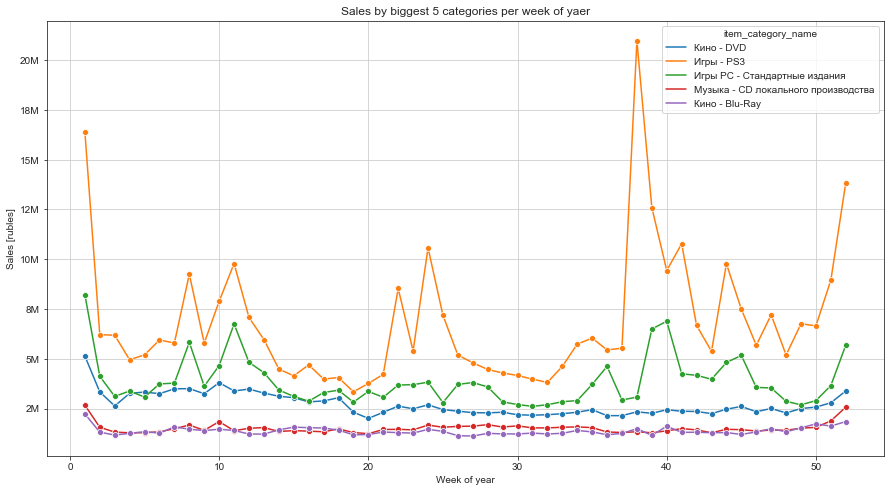

In [174]:
plt.figure(figsize=(15,8))
sales_5_cats_by_week_of_year = pd.read_csv('results/sales_5_cats_by_week_of_year/sales_5_cats_by_week_of_year.csv').join(cat_names.set_index('item_category_id'), on='item_category_id')
ax = sns.lineplot(data=sales_5_cats_by_week_of_year, x='week_of_year', y='sales',hue='item_category_name', palette='tab10', marker='o')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/10**6:,.0f}M'))
plt.title('Sales by biggest 5 categories per week of yaer')
plt.xlabel('Week of year')
plt.ylabel('Sales [rubles]');
plt.grid()

Here we can see a distribution of sales by week of year and 5 categories. We see that PS3 games and PC games have spikes at the same time, which may be attributed to the releases of new game, which quite often are released togather both on PS and PC.

### Distribution of sales by categories and month of year

```python
sales_5_cats_by_month_of_year = sales_w_days_cats.groupBy('month', 'item_category_id') \
    .agg(F.sum(sales_w_days.item_price * sales_w_days.item_count_day).alias('sales')).orderBy('month')
sales_5_cats_by_month_of_year.coalesce(1).write.mode('overwrite') \
    .csv('semestral-project/results/sales_5_cats_by_month_of_year', header=True)
```

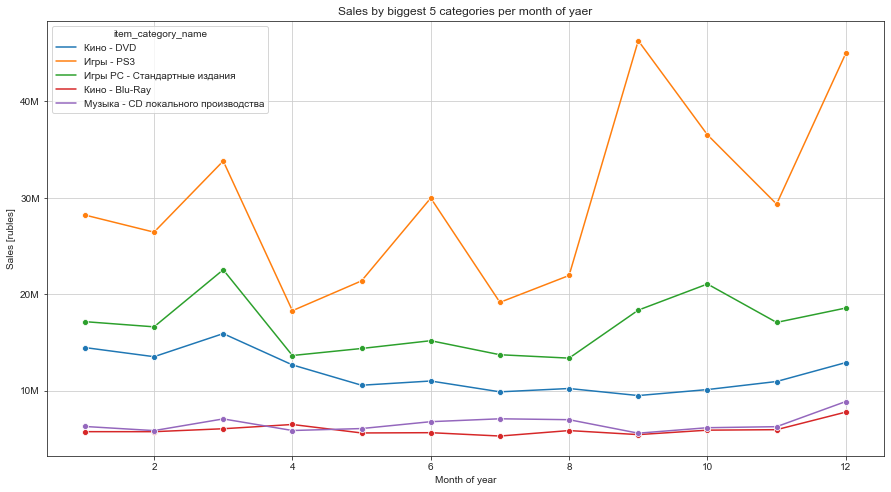

In [177]:
sales_5_cats_by_month_of_year = pd.read_csv('results/sales_5_cats_by_month_of_year/sales_5_cats_by_month_of_year.csv').join(cat_names.set_index('item_category_id'), on='item_category_id')
plt.figure(figsize=(15,8))
ax = sns.lineplot(data=sales_5_cats_by_month_of_year, x='month', y='sales',hue='item_category_name', palette='tab10', marker='o')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/10**6:,.0f}M'))
plt.title('Sales by biggest 5 categories per month of yaer')
plt.xlabel('Month of year')
plt.ylabel('Sales [rubles]');
plt.grid()

On this plot we see distribution of sales by categories and month of year. Here we see that PS3 games have high degree of variability and probably this means that they belong to BZ category.

# Summary

In this report we presented the analysis of sales of Russian software firm 1C Company. Inital data consist of time-series of daily sales by products. Output of this report is the following 

1. ABC/XYZ analysis 
1. Analysis of distribution of average prices of products
1. Analysis of distribution of prices in 5 most sold product categories
1. Analysis of distribution of prices by categories
1. We showed top 10 items with biggest sales from AX, BX and CZ categories from ABC/XYZ analysis
1. Time-series analysis of total sales 
1. Analysis of total sales by days of week, days of month, weeks of year and months of year
1. Similar analysis as in the point above, but for 5 most sold categories

ABC/XYZ analysis helps buisness to manage their inventory and identify items which will need different management strategies. We saw that around 900 out of approximately 20000 products constitute 70% of sales and this should be most prioritised items. We also saw that roughly 11000 products belong to CZ category and produce only 4% of total sales and the fact that they belong to Z category means that they have highly variable demand.

We showed the histogram of average prices of products and we saw that distribution of prices is right-skewed and that 75% of products are priced below 900 rubles. Also we shoed top 10 most expensive products which mostly consist of software and gaming consoles.

We showed 5 categories with biggest amount of sales and we found out that this is entertainment categories with video games, music and movies on DVDs. We also saw the distribution of average prices for each of these categories. In 4 out of these 5 categories average price does not exceed 1500 rubles, while more expensive category was games for PS3.

We showed the histogram of distribution of average prices by categories. We saw that the distribution is right-skewed and 75% of categories have avareage price below 1600 rubles.

We showed 3 tables with top 10 products by sales for AX, BX and CZ categories. We found out that most profitable items from AX and BX categories are mostly video games. Top 10 products from CZ category belong to absolutely different types of categories and the total sales for each product from this category does not exceed 50000 rubles.

We also performed time-series analysis of sales by days, weeks and months. We saw a cyclic behavior of sales in plot with daily data and some spikes around winter holidays. From the plots with weekly and monthly data frequency we saw again that sales are higher during winter holidays and lower during summer.

We further analysed cyclic behavior of sales by ploting distribution of sales by days of week, days of month, weeks of year and months of year. We saw that most sales are higher during Saturday, Sunday and Monday with relative spike on Wednesday. From the plot with days of month we saw that sales are higher during beging mid-end and end of month. From the plot with weeks of year we noticed that on the first week of year there are still high sales and we explained it by Christams in Russia. And from montlhy plot we confirmed the spikes in winter and lows in summer.

In the last part we examined cyclicity of sales by top 5 categories with most sales, they showed us pretty similar results as in point above, but we also saw high variability in category of PS3 games.

And with this we conclude our analysis.
